# The Eight-School Problem in PyStan

This hierarchical model is often called the “eight schools” model. The eight schools problem ([Rubin 1981](https://journals.sagepub.com/doi/abs/10.3102/10769986006004377?journalCode=jeba)) considers the effectiveness of SAT coaching programs conducted in parallel at eight schools. It has become a classic problem (Bayesian Data Analysis, Stan) that illustrates the usefulness of hierarchical modeling for sharing information between exchangeable groups. 

From the [book](http://www.stat.columbia.edu/~gelman/book/) Bayesian Data Analysis, section 5.5 (Gelman et al. 2013):


> A study was performed for the Educational Testing Service to analyze the effects of special coaching programs for SAT-V (Scholastic Aptitude Test-Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be very successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.

The eight-schools problem has been implemented in many different Python frameworks and documented online:

1. [PyStan example](https://pystan.readthedocs.io/en/latest/getting_started.html)
1. [TensorFlow example](https://www.tensorflow.org/probability/examples/Eight_Schools)  
1. [Edward example](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb)

This notebook replicates the PyStan and TensorFlow examples.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# PyStan

> https://pystan.readthedocs.io/en/latest/getting_started.html


In [4]:
import stan

# necessary to run stan in Jupyter Notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

print(stan.__version__)

3.6.0


## Stan code

To model using Stan you must create a Stan "program", which contains parameters and model specification. In Python, you write the program inside a string literal. The language inside the string is not Python, but rather a separate language called [Stan](https://mc-stan.org/).

In [5]:
schools_code = """
data {
  int<lower=0> J;         // number of schools
  real y[J];              // estimated treatment effects
  real<lower=0> sigma[J]; // standard error of effect estimates
}
parameters {
  real mu;                // population treatment effect
  real<lower=0> tau;      // standard deviation in treatment effects
  vector[J] eta;          // unscaled deviation from mu by school
}
transformed parameters {
  vector[J] theta = mu + tau * eta;        // school treatment effects
}
model {
  target += normal_lpdf(eta | 0, 1);       // prior log-density
  target += normal_lpdf(y | theta, sigma); // log-likelihood
}
"""

In [6]:
schools_data = {"J": 8,
                "y": [28,  8, -3,  7, -1,  1, 18, 12],
                "sigma": [15, 10, 16, 11,  9, 11, 10, 18]}

In [7]:
posterior = stan.build(schools_code, data=schools_data, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_9b7xmj7s/model_qhycwete.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_9b7xmj7s/model_qhycwete.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [8]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


In [9]:
eta = fit["eta"]  # array with shape (8, 4000)
eta

array([[ 0.06569064,  1.07555266, -0.55215545, ...,  1.41114167,
        -0.55744645, -0.86580196],
       [ 0.38732515,  0.84298643, -0.11625492, ..., -0.85416625,
         1.94558782, -1.09278351],
       [-0.70225196,  0.51324704, -1.59100185, ..., -2.4886128 ,
         1.10105798,  0.45169692],
       ...,
       [ 0.2013854 ,  0.83863796, -1.11845423, ...,  0.70655335,
         0.12869399,  0.29676855],
       [ 0.75224962,  0.27064642,  1.07229314, ...,  0.05187624,
         0.52653385,  0.0886355 ],
       [-0.21515163,  1.17637997, -0.96446302, ..., -0.40114063,
         0.90874234,  1.02801608]])

In [10]:
df = fit.to_frame()
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,tau,eta.1,...,eta.7,eta.8,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8
draws,,,,,,,,,,,,,,,,,,,,,
0,-39.543857,0.981149,0.456114,3.0,7.0,0.0,43.901917,1.631685,10.814233,0.065691,...,0.752250,-0.215152,2.342079,5.820310,-5.962631,-7.895006,-17.302932,3.809514,9.766688,-0.695014
1,-38.413396,0.971546,0.374037,3.0,7.0,0.0,42.403550,11.124495,9.920062,1.075553,...,0.270646,1.176380,21.794044,19.486973,16.215938,3.672061,3.415187,19.443835,13.809324,22.794257
2,-43.077909,0.748105,0.318949,3.0,15.0,0.0,47.439749,13.817962,0.524344,-0.552155,...,1.072293,-0.964463,13.528442,13.757004,12.983729,12.967678,13.916853,13.231507,14.380213,13.312251
3,-37.736952,0.996073,0.379144,4.0,15.0,0.0,42.151985,5.978616,5.649707,1.064808,...,-0.448153,0.360636,11.994471,12.075848,0.252708,12.034185,3.207920,1.592048,3.446685,8.016102
4,-39.132581,0.903167,0.456114,3.0,7.0,0.0,46.927763,1.552166,11.159276,1.119787,...,0.302080,-0.553535,14.048173,14.496251,0.315351,-8.456743,-13.383802,-3.543713,4.923157,-4.624884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-40.065425,0.953863,0.379144,3.0,15.0,0.0,44.796814,13.113175,5.680845,-0.638008,...,-0.267726,0.633015,9.488752,3.264173,15.895823,6.799751,11.138503,18.352544,11.592265,16.709237
3996,-42.219517,0.757442,0.456114,3.0,7.0,0.0,45.549102,21.316550,7.252320,-0.870831,...,0.871725,-1.293797,15.001008,12.987491,24.888800,24.077962,14.491825,19.671462,27.638577,11.933518
3997,-41.141443,0.826285,0.374037,3.0,7.0,0.0,42.428003,9.709897,3.022275,1.411142,...,0.051876,-0.401141,13.974755,7.128372,2.188625,12.853743,7.115964,11.845296,9.866681,8.497540


## TensorFlow

> https://www.tensorflow.org/probability/examples/Eight_Schools

In [11]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import warnings

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

2023-04-13 09:40:57.927643: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 09:40:59.027102: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 09:40:59.059816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 09:41:04.418025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Problem definition:
- For each of the eight schools $J=8$, we have an estimated treatment effect $y_j$
and a standard error of the effect estimate $\sigma_j$. 
- The treatment effects in the study were obtained by a linear regression on the treatment group using PSAT-M and PSAT-V scores as control variables. 
- As there was no prior belief that any of the schools were more or less similar or that any of the coaching programs would be more effective, we can consider the treatment effects as exchangeable.

TODO: replicate the linear regression that estimates the treatment effects.

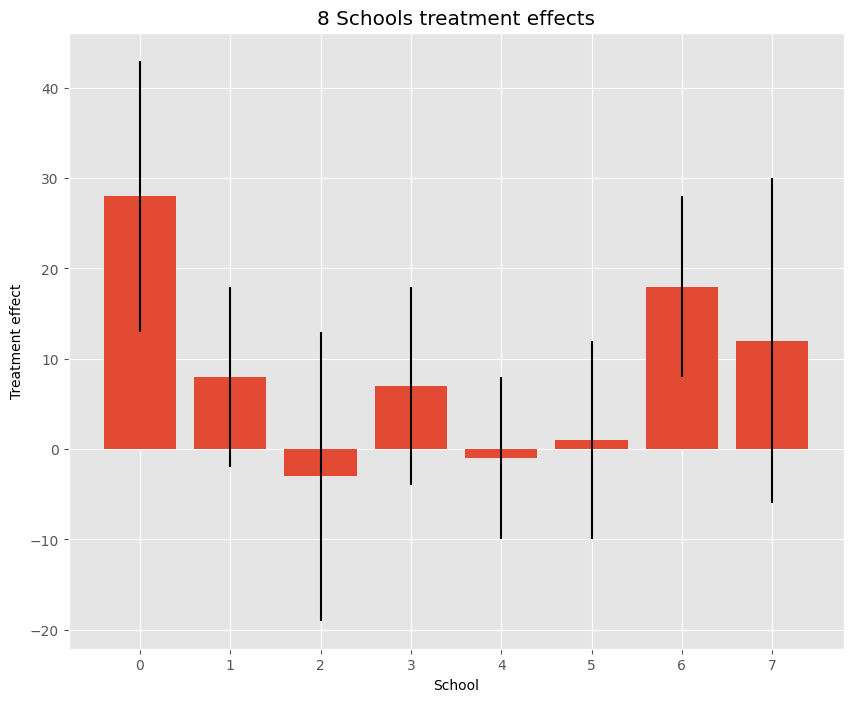

In [12]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

### Model

To capture the data, we use a hierarchical normal model. It follows the generative process,

$$
\begin{align}
\mu \sim & \: Normal(loc=0, scale=10) \\
\log \tau \sim & \: Normal(loc=5, scale=1) \\
\theta_i \sim & \: Normal(loc=\mu, scale=\tau) \\ 
y_i \sim & \: Normal(loc=\theta_j, scale=\sigma_i) \\
\end{align}
$$

- $\mu$ represents the prior average treatment effect (assumed to be nothing).
- $\tau$ controls how much variance there is between schools
- $y_i$ and $\sigma_i$ are observed
- As $\tau \rightarrow \infty$, the model approaches the no-pooling model, i.e., each of the school treatment effect estimates are allowed to be more independent. As $\tau \rightarrow 0$, the model approaches the complete-pooling model, i.e., all of the school treatment effects are closer to the group average.
- To restrict the standard deviation to be positive, we draw $\tau$ from a lognormal distribution (which is equivalent to drawing $log(\tau)$ from a normal distribution).

Following [Diagnosing Biased Inference with Divergences](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html), we transform the model above into an equivalent non-centered model:

$$
\begin{align}
\mu \sim & \: Normal(loc=0, scale=10) \\
\log \tau \sim & \: Normal(loc=5, scale=1) \\
\theta_i' \sim & \: Normal(loc=0, scale=1) \\
\theta_i = & \: \mu + \tau \theta_i' \\
y_i \sim & \: Normal(loc=\theta_j, scale=\sigma_i) \\
\end{align}
$$

We reify (make something abstract more real) this model as a [JointDistributionSequential](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionSequential) instance in the code below.

In [13]:
def func(school_effects_standard, avg_stddev, avg_effect):
    return (
        tfd.Independent(tfd.Normal(loc=(avg_effect[..., tf.newaxis] +
                                        tf.exp(avg_stddev[..., tf.newaxis]) *
                                        school_effects_standard),  # `theta` above
                                   scale=treatment_stddevs),
                        name="treatment_effects",  # `y` above
                        reinterpreted_batch_ndims=1))


model = tfd.JointDistributionSequential([
    tfd.Normal(loc=0., scale=10., name="avg_effect"),  # `mu` above
    tfd.Normal(loc=5., scale=1., name="avg_stddev"),  # `log(tau)` above
    tfd.Independent(tfd.Normal(loc=tf.zeros(num_schools),
                               scale=tf.ones(num_schools),
                               name="school_effects_standard"),  # `theta_prime`
                    reinterpreted_batch_ndims=1),
    func
])


def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
    """Unnormalized target density as a function of states."""
    return model.log_prob((
        avg_effect, avg_stddev, school_effects_standard, treatment_effects))


### Bayesian Inference

Given data, we perform Hamiltonian Monte Carlo (HMC) to calculate the posterior distribution over the model's parameters.

In [14]:
num_results = 5000
num_burnin_steps = 3000

# Improve performance by tracing the sampler using `tf.function`
# and compiling it using XLA.
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.zeros([], name='init_avg_effect'),
          tf.zeros([], name='init_avg_stddev'),
          tf.ones([num_schools], name='init_school_effects_standard'),
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.4,
          num_leapfrog_steps=3))

states, kernel_results = do_sampling()

avg_effect, avg_stddev, school_effects_standard = states

school_effects_samples = (
    avg_effect[:, np.newaxis] +
    np.exp(avg_stddev)[:, np.newaxis] * school_effects_standard)

num_accepted = np.sum(kernel_results.is_accepted)
print('Acceptance rate: {}'.format(num_accepted / num_results))

2023-04-13 09:41:10.766781: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55d290accef0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-13 09:41:10.766830: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2023-04-13 09:41:12.119780: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-13 09:41:12.820296: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed


Acceptance rate: 0.6264


2023-04-13 09:41:17.022539: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


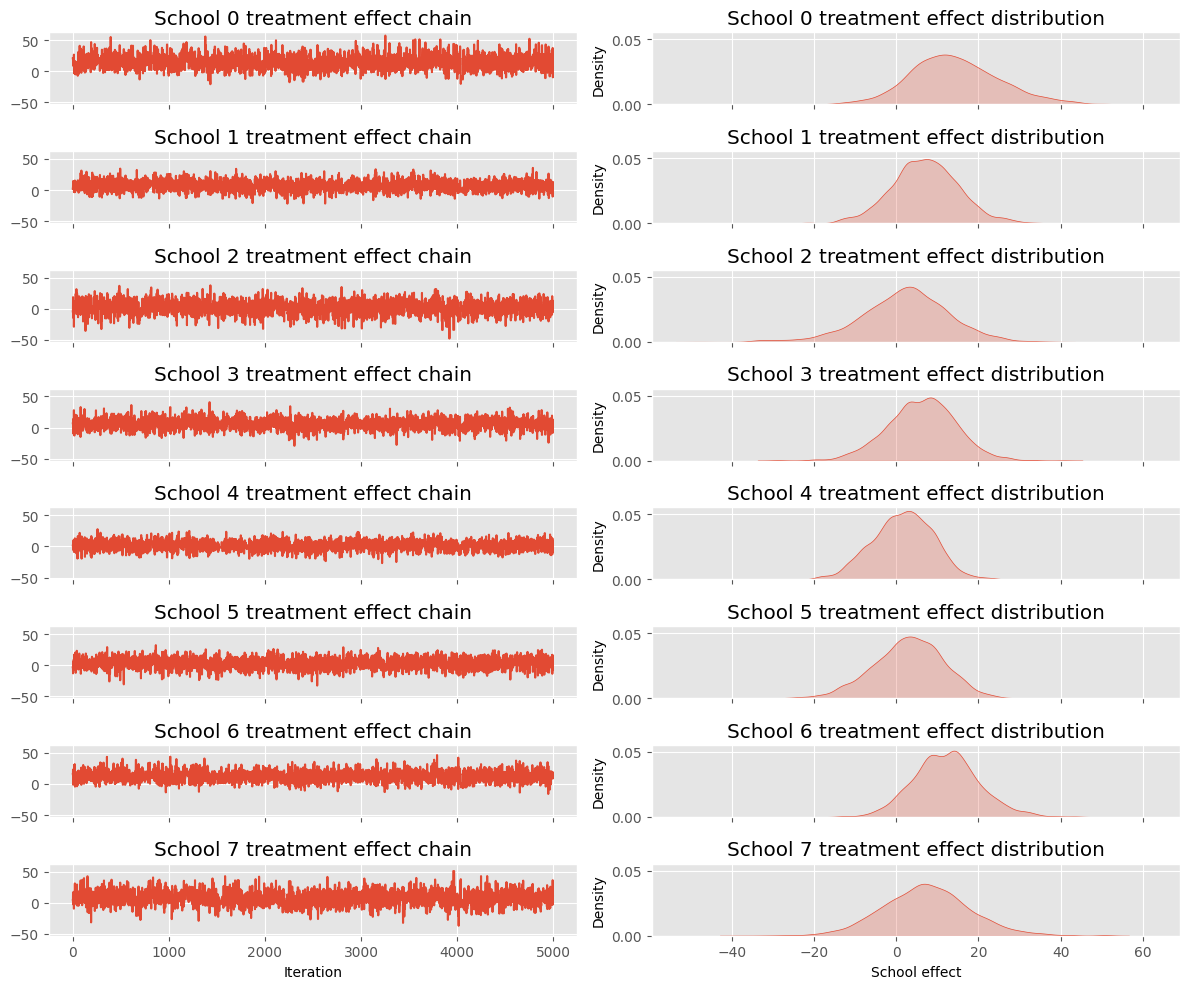

In [15]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i].numpy())
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i].numpy(), ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [16]:
print("E[avg_effect] = {}".format(np.mean(avg_effect)))
print("E[avg_stddev] = {}".format(np.mean(avg_stddev)))
print("E[school_effects_standard] =")
print(np.mean(school_effects_standard[:, ]))
print("E[school_effects] =")
print(np.mean(school_effects_samples[:, ], axis=0))

E[avg_effect] = 4.9714179039001465
E[avg_stddev] = 2.4532148838043213
E[school_effects_standard] =
0.12081703
E[school_effects] =
[14.361342   7.0179877  2.1304083  6.1470804  1.5497569  2.910861
 12.218837   7.385467 ]


In [17]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(num_schools)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(num_schools)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(num_schools)
])

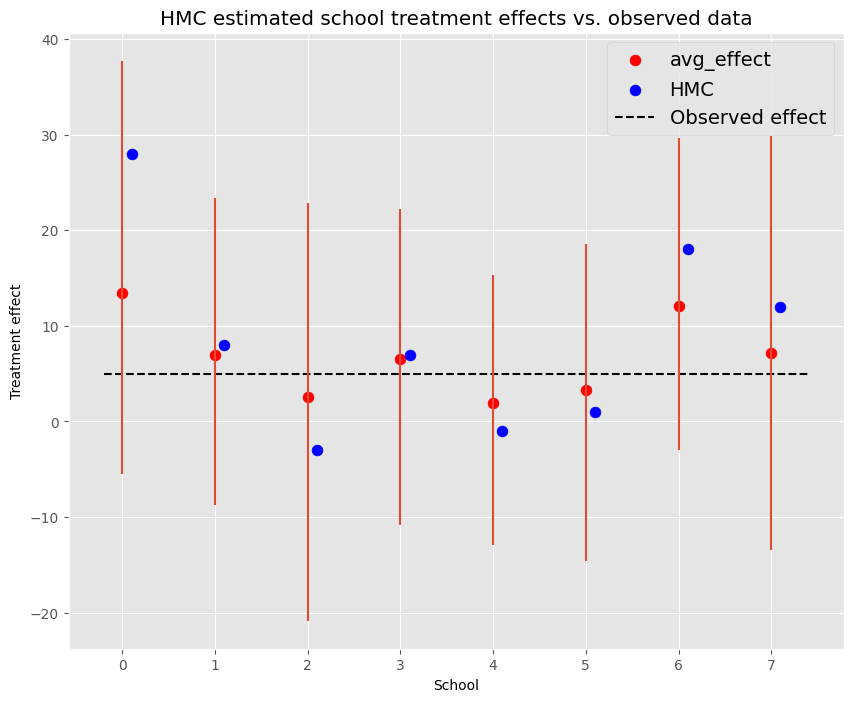

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(num_schools)), school_effects_med, color='red', s=60)
ax.scatter(
    np.array(range(num_schools)) + 0.1, treatment_effects, color='blue', s=60)

plt.plot([-0.2, 7.4], [np.mean(avg_effect),
                       np.mean(avg_effect)], 'k', linestyle='--')

ax.errorbar(
    np.array(range(8)),
    school_effects_med,
    yerr=[
        school_effects_med - school_effects_low,
        school_effects_hi - school_effects_med
    ],
    fmt='none')

ax.legend(('avg_effect', 'HMC', 'Observed effect'), fontsize=14)

plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('HMC estimated school treatment effects vs. observed data')
fig.set_size_inches(10, 8)
plt.show()

In [19]:
print("Inferred posterior mean: {0:.2f}".format(
    np.mean(school_effects_samples[:,])))
print("Inferred posterior mean se: {0:.2f}".format(
    np.std(school_effects_samples[:,])))

Inferred posterior mean: 6.72
Inferred posterior mean se: 10.20


### Criticism

To get the posterior predictive distribution, i.e., a model of new data $y^*$ given the observed data $y$:

$$
p(y^*|y) \propto \int_\theta p(y^*|\theta)p(\theta|y)d\theta
$$

we override the values of the random variables in the model to set them to the mean of the posterior distribution, and sample from that model to generate new data 
.

In [20]:
sample_shape = [5000]

_, _, _, predictive_treatment_effects = model.sample(
    value=(tf.broadcast_to(np.mean(avg_effect, 0), sample_shape),
           tf.broadcast_to(np.mean(avg_stddev, 0), sample_shape),
           tf.broadcast_to(np.mean(school_effects_standard, 0),
                           sample_shape + [num_schools]),
           None))

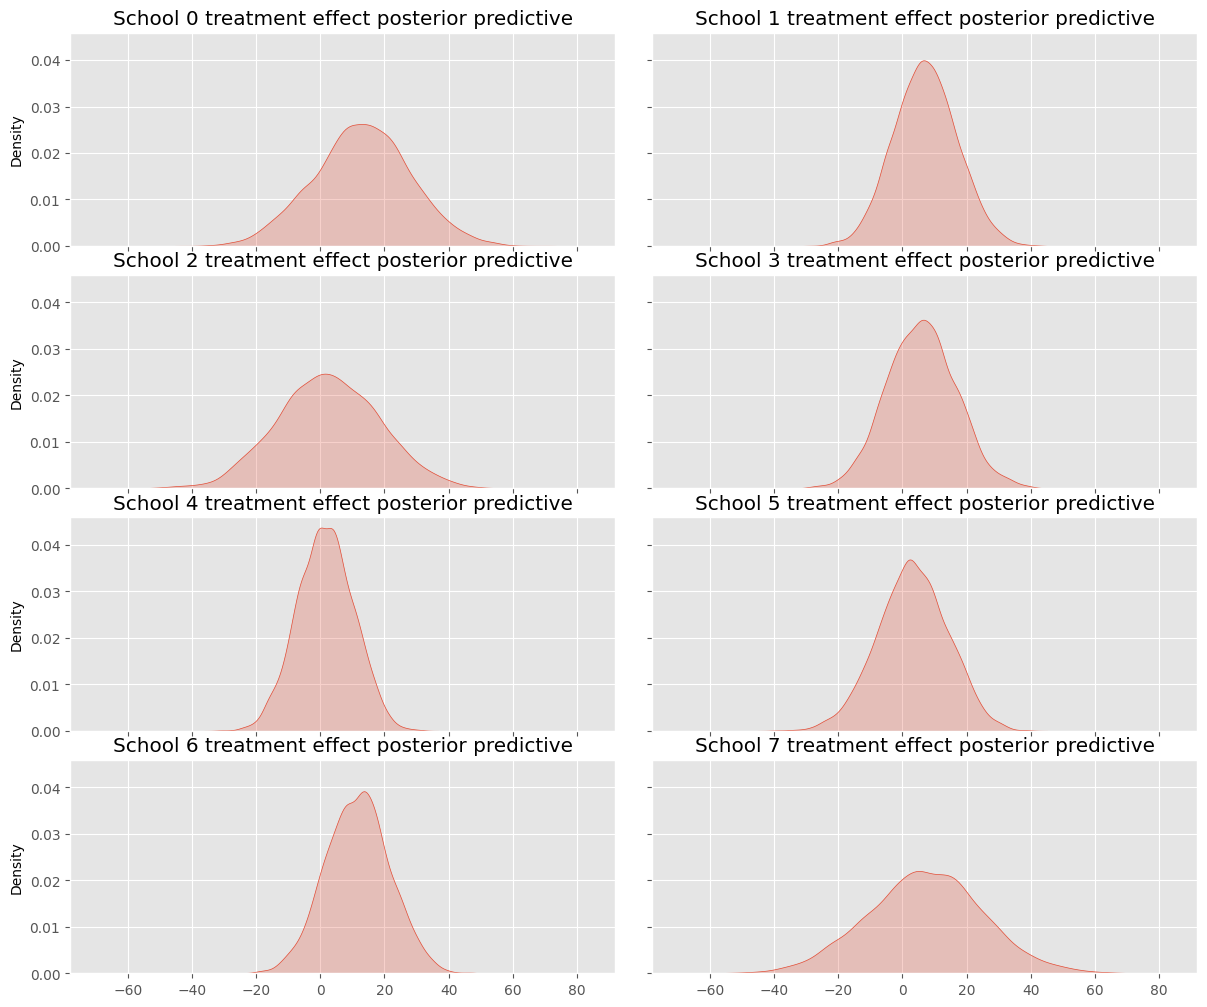

In [21]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(predictive_treatment_effects[:, 2*i].numpy(),
              ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i))
  sns.kdeplot(predictive_treatment_effects[:, 2*i + 1].numpy(),
              ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i + 1))
plt.show()

In [22]:
# The mean predicted treatment effects for each of the eight schools.
prediction = np.mean(predictive_treatment_effects, axis=0)

We can look at the residuals between the treatment effects data and the predictions of the model posterior. These correspond with the plot above which shows the shrinkage of the estimated effects toward the population average.

<Axes: >

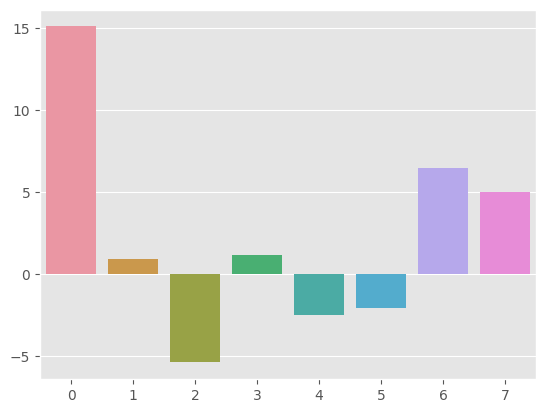

In [23]:
sns.barplot(x=np.arange(8), y=treatment_effects - prediction)

In [24]:
residuals = treatment_effects - predictive_treatment_effects

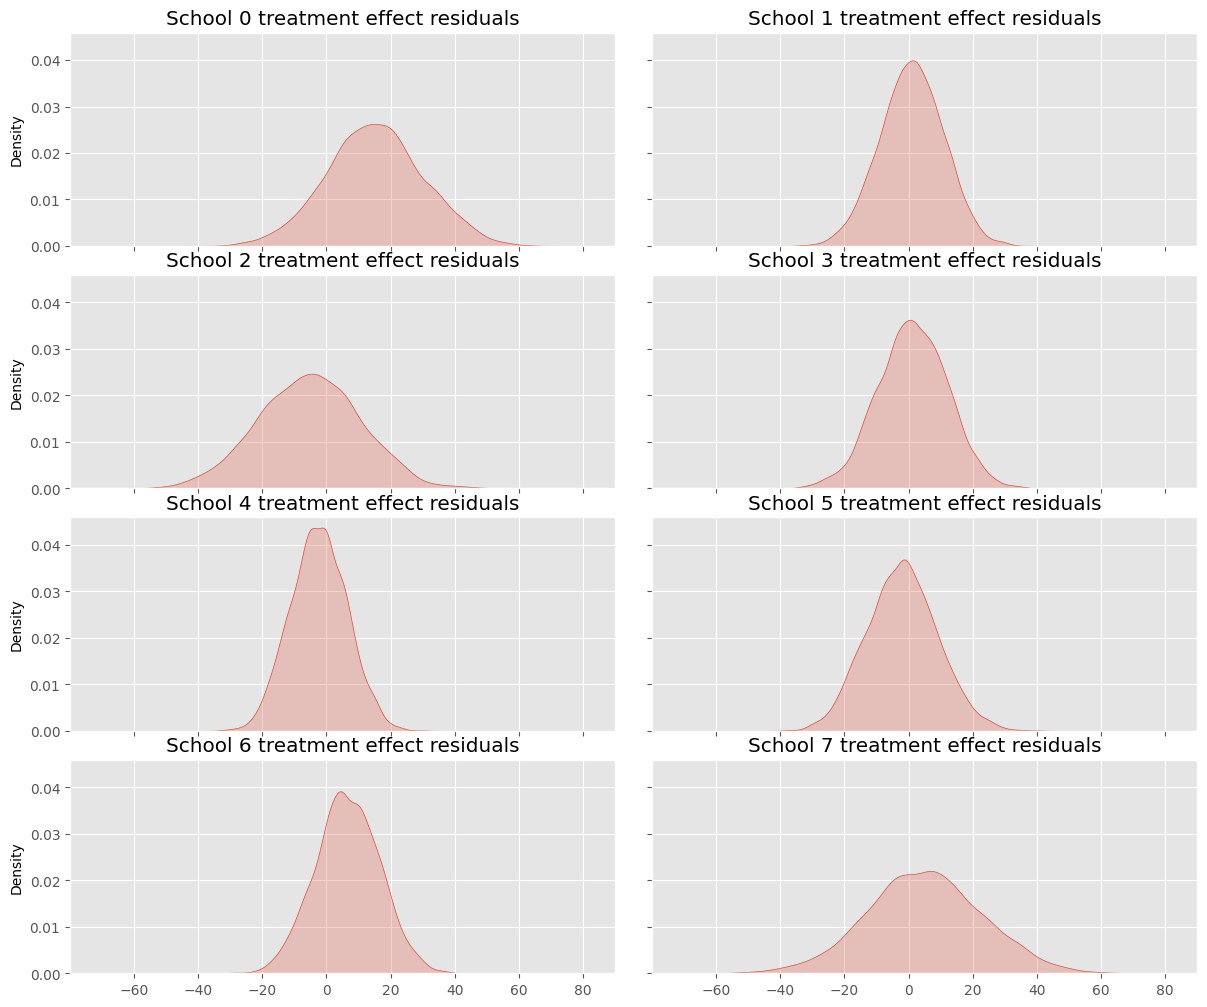

In [25]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(residuals[:, 2*i].numpy(), ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect residuals".format(2*i))
  sns.kdeplot(residuals[:, 2*i + 1].numpy(), ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect residuals".format(2*i + 1))
plt.show()

## References

1. Donald B. Rubin. Estimation in parallel randomized experiments. Journal of Educational Statistics, 6(4):377-401, 1981.
1. Andrew Gelman, John Carlin, Hal Stern, David Dunson, Aki Vehtari, and Donald Rubin. Bayesian Data Analysis, Third Edition. Chapman and Hall/CRC, 2013.

## Keywords for further study

- Hamiltonian Monte Carlo (HMC)
    - [Introduction to Markov chain Monte Carlo (MCMC)](https://youtu.be/12eZWG0Z5gY) (~ 15m) - mathematicalmonk
    - [The intuition behind the Hamiltonian Monte Carlo (HMC)](https://youtu.be/a-wydhEuAm0) (~ 30m) - Ben Lambert
    - [Statistical Rethinking - Markov Chain Monte Carlo](https://youtu.be/rZk2FqX2XnY) (~ 1h 15m) - Richard McElreath